In [45]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from helper_funcs import load_spike_times_data, plot_isis, restrict_spike_times, exponential, linear, inverse
import ipywidgets as widgets
from ipywidgets import interactive, fixed, interact

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
filename = 'https://osf.io/sy5xt/download'
spike_times_data = load_spike_times_data(filename)

In [13]:
type(spike_times_data), spike_times_data.shape, type(spike_times_data[10]), spike_times_data[10].shape

(numpy.ndarray, (734,), numpy.ndarray, (625,))

In [14]:
[len(spike_times_data[i]) for i in range(10)]

[826, 2818, 3953, 646, 1115, 457, 10305, 3849, 1225, 2487]

In [10]:
spike_times_data

array([array([8.1489998e-01, 1.4822467e+01, 2.4964600e+01, 2.5143600e+01,
              3.8870899e+01, 5.0820801e+01, 5.4806866e+01, 5.9511833e+01,
              8.0470367e+01, 1.2709637e+02, 1.6678714e+02, 1.7524760e+02,
              1.7728830e+02, 1.7831754e+02, 2.3178033e+02, 2.4066676e+02,
              2.7128897e+02, 3.0554150e+02, 3.0564987e+02, 3.1116019e+02,
              3.1275296e+02, 3.1846918e+02, 3.2280109e+02, 3.2485114e+02,
              3.5686102e+02, 3.5699719e+02, 3.7701962e+02, 3.8818140e+02,
              3.9037332e+02, 4.3421207e+02, 4.4229883e+02, 4.7392587e+02,
              4.8475021e+02, 5.0332483e+02, 5.0333578e+02, 5.0336313e+02,
              5.0341571e+02, 5.3048364e+02, 5.7414423e+02, 5.8498682e+02,
              5.8690369e+02, 5.9334210e+02, 6.1483112e+02, 6.5422388e+02,
              6.5453082e+02, 6.5481042e+02, 7.1913885e+02, 7.3967511e+02,
              7.4461981e+02, 7.4536530e+02, 7.5823090e+02, 7.5842230e+02,
              7.6530389e+02, 7.7090735

In [19]:
total_spikes_per_neuron = [len(spike_times_data[i]) for i in range(len(spike_times_data))]
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


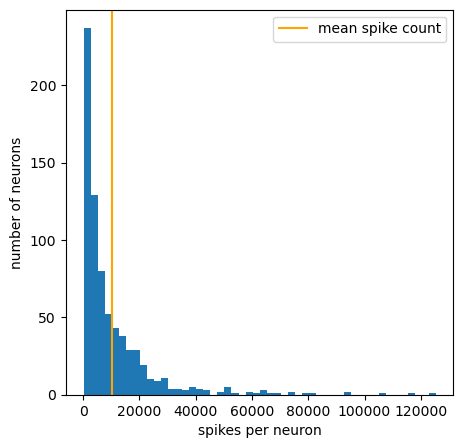

In [22]:
fig,ax = plt.subplots(figsize=(5, 5))
ax.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(mean_spike_count, color="orange",label="mean spike count")
ax.legend()
ax.set_xlabel("spikes per neuron");
ax.set_ylabel("number of neurons");

## Coding Exercise 1.2: Comparing mean and median neurons

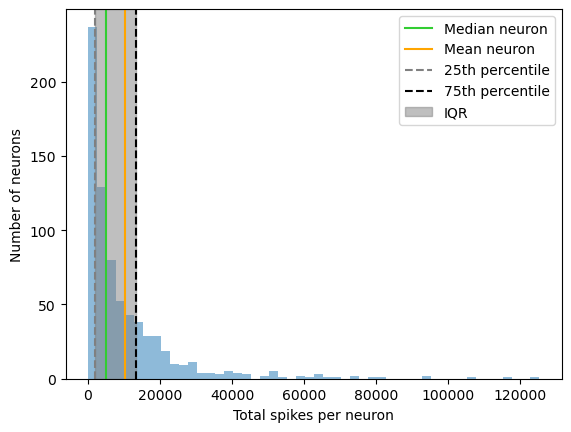

In [26]:
#################################################################################
## TODO for students:
# Fill out function and remove
# raise NotImplementedError("Student exercise: complete histogram plotting with median")
#################################################################################

# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median
spike_count_25th_perentile = np.percentile(total_spikes_per_neuron, 25)
spike_count_75th_perentile = np.percentile(total_spikes_per_neuron, 75)

# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled", color="tab:blue", alpha=0.5)
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.axvline(spike_count_25th_perentile, color="gray", ls="--", label="25th percentile")
plt.axvline(spike_count_75th_perentile, color="k", ls="--", label="75th percentile")
plt.axvspan(xmin=spike_count_25th_perentile, xmax=spike_count_75th_perentile, color="grey",alpha=0.5, label="IQR")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

In [31]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times_data, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times_data])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

spike_times_flat = np.concatenate(spike_times_data)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.33% of the total spikes are in the interval
0.37% of the total time is in the interval


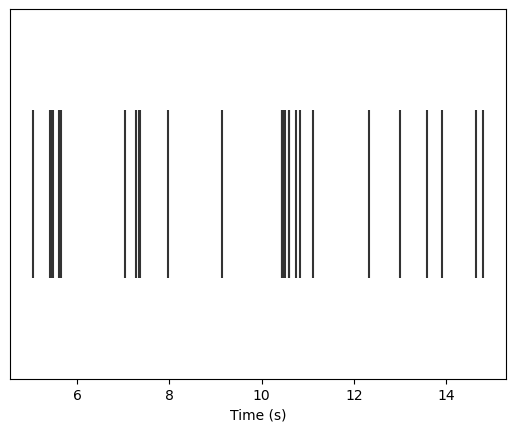

In [32]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

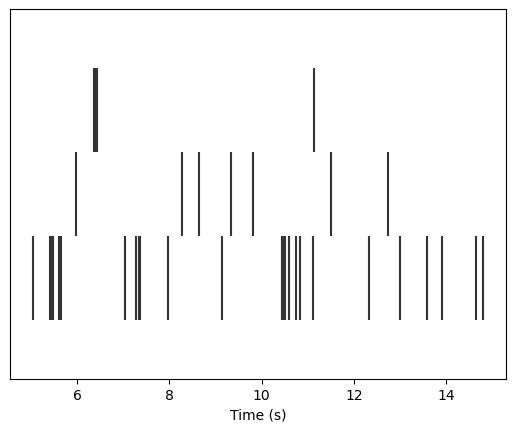

In [33]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

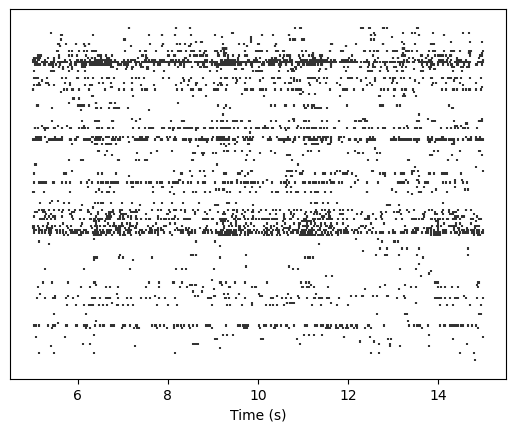

In [34]:
neuron_idx = np.arange(0, len(spike_times_data), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

## Exercise 3: Plot the distribution of ISIs for a single neuron

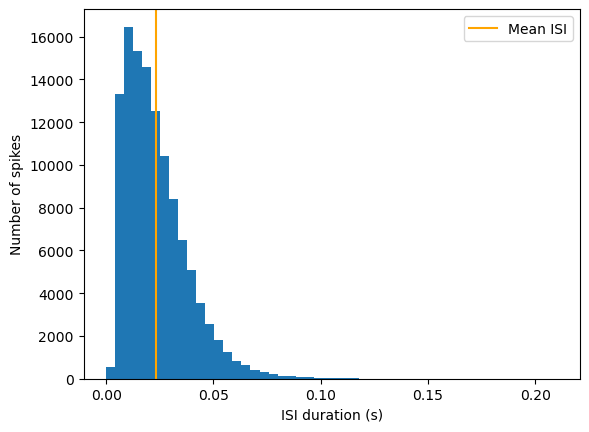

In [36]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  #############################################################################
  # Students: Fill in missing code (...) and comment or remove the next line
#   raise NotImplementedError("Exercise: compute single neuron ISIs")
  #############################################################################

  # Extract the spike times for the specified neuron
  single_neuron_spikes = ...

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(spike_times[neuron_idx])

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times_data, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

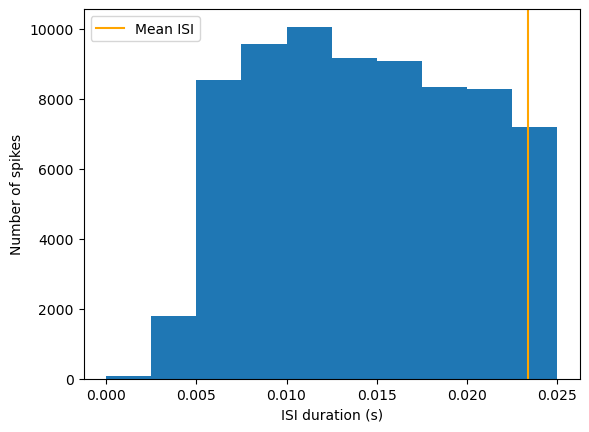

In [44]:
plot_isis(single_neuron_isis, bins=10, histrange=(0,0.025))

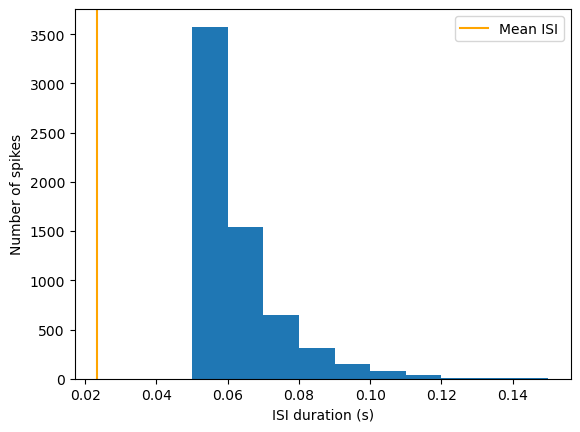

In [41]:
plot_isis(single_neuron_isis, bins=10, histrange=(0.05,0.15))

In [46]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times_data[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…